In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback,
)
from lib.sde.grn.grn4 import GRNMain4 as GRNMain
from lib.sde.mutate import mutate_grn4 as mutate_grn

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from lib.utils import pick_best, pick_last
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve, show_curve_progenitor
from jf.models.stringmodel import read_model
from lib.utils import normalize_time, align_time

In [3]:
_count = -1
def provide_id():
    global _count
    _count += 1
    return _count

In [4]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)
SM_GEN = read_model("generation")

In [5]:
def individual_generator(id_=-1, cb_init=None):
    return Solution(GRNMain(5, 0, 1, generate_funcs=cb_init), id_=id_)

In [6]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        mutate_grn(self.grn)

In [7]:
def score_bb_size(bb, ref, *args, **kwargs):
    stats = bb.stats.copy()
    stats, ref_stats = align_time(stats, ref.stats)
    stats_p, ref_p = normalize_time(stats, ref_stats, "progenitor_pop_size", "progenitor_pop_size")
    stats_n, ref_n = normalize_time(stats, ref_stats, "neuron_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    last_time_stats, last_time_ref = max(stats.time), max(ref_stats.time)
    
    ref_p = ref_p.set_index("time")
    ref_n = ref_n.set_index("time")
    stats_p = stats_p.set_index("time")
    stats_n = stats_n.set_index("time")
    
    prog = stats_p.loc[last_time_stats]["progenitor_pop_size"]
    neuron = stats_n.loc[last_time_stats]["neuron_pop_size"]
    
    ref_prog = ref_p.loc[last_time_ref]["progenitor_pop_size"]
    ref_neuron = ref_n.loc[last_time_ref]["neuron_pop_size"]

    return (prog - ref_prog)**2 + (neuron - ref_neuron)**2

In [8]:
def setup_tag(cp):
    indexes = list(cp.base_population.keys())
    shuffle(indexes)
    splits = np.array_split(indexes, 3)
    for i, ls in enumerate(splits):
        for idx in ls:
            cp.base_population[idx].tag["subbrain"] = i

In [9]:
def get_bb(prun, grn):
    ccls = factories["grn5"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
    )
    bb = BrainModel(time_step=0.5, verbose=False, start_population=prun.size, max_pop_size=5e2,
            cell_cls=ccls, end_time=prun.end_time, start_time=56, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks, tag_func=setup_tag)
    return bb

In [10]:
def run_grn(prun, grn):
    get_bb(prun, grn)
    bb.run()
    return bb

In [11]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb.stats

In [12]:
def do_init(prun):
    return individual_generator(provide_id(), prun.cb_init)

def do_fitness(prun, sol):
    fitness, stats = fitness_multistep(prun, sol.grn, prun.steps)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id(), prun.cb_init)
    
    pop_fit = normalize_fitness_values(pop_fit)
    
    return weighted_selection_one(pop, pop_fit, lambda x: individual_generator(x, prun.cb_init), new_fitness=0.05, id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [13]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 1e9
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True
    
example_steps = [
    # ObjectiveStep(name="1", start_time=50, end_time=53, score_func=score_bb_size, min_fitness=0.2),
    # ObjectiveStep(name="2", start_time=53, end_time=56, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="3", start_time=56, end_time=86, score_func=score_bb_size, min_fitness=0.2),
]

class ParamRun(O):
    pop_size = 50
    batch_size = 50
    n_gen = 50
    current_gen = 0
    end_time = 86
    ref = REF
    min_pop = 50
    max_pop = 50

def get_prun(size=7, exponent=1):
    prun = ParamRun()
    prun.cb_init = dict()
    prun.size = size
    prun.exponent = exponent
    prun.steps = example_steps
    return prun

In [14]:
def pick_last_exported(exporter):
    generations = list(filter(SM_GEN.match, exporter.list()))
    if len(generations) == 0:
        return None, 0
    
    last = max(generations, key=lambda x: int(SM_GEN.extract(x).get("generation")))
    b_gen = int(SM_GEN.extract(last).get("generation")) + 1
    exporter.print(f"Found generation {b_gen - 1}", "reload")
    pop = exporter.load(last)
    return pop, b_gen

In [15]:
def main(prun):
    prun.history = dict()
    exporter = Exporter(name=prun.name, copy_stdout=True)
    definition = """
    
    """
    exporter.print(definition, slot="definition")
    best = 0
    
    # setup
    pop, batch_gen = pick_last_exported(exporter)
    
    if pop is None:
        sol = do_init(prun)
        pop = [sol]
        batch_gen = 0
    else:
        sol = pop[-1]
        
    for i in range(batch_gen * prun.batch_size,
                   prun.n_gen * prun.batch_size):
        fit, stats = do_fitness(prun, sol)
        sol.fit, sol.stats = fit, stats
        
        if i % 100 == 0:
            exporter.print(f"Step {i}")
        if fit > best:
            exporter.print(f"++ Best {fit} for generation {i}")
            best = fit
            
        monitor = sol
        prun.history[i] = monitor
        # exporter(monitor, f"generation_g{generation}")
        
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
        if (i + 1) % prun.batch_size == 0:
            print("Saving ...")
            batch_gen = (i + 1) // 100
            exporter(pop[-prun.max_pop:], SM_GEN.fill(generation=batch_gen))
        
    return best

In [16]:
callback_init = dict(
    init=lambda: np.random.beta(1.5, 3) * 3,
    b=lambda: np.random.beta(1.5, 3) * 5,
    expr=lambda: 1,
    deg=lambda: 0.1,
    noise=lambda: np.random.beta(1.5, 3) * 1,
    asym=lambda: 5,
)

In [17]:
prun = get_prun()
prun.cb_init = callback_init
prun.name = "check_simple_obj_r5"
res = main(prun)

Exporting at output/check_simple_obj_r5
[definition] 
    
    
[out] Step 0
[out] ++ Best 0.0014099923753947917 for generation 0
[out] ++ Best 0.001650323965635553 for generation 1
[out] ++ Best 0.0017333924299605553 for generation 2
[out] ++ Best 0.020688300108161042 for generation 3
Saving ...
Step 3 passed !
[out] ++ Best 0.3858847256981701 for generation 60
[out] ++ Best 0.6059905712390122 for generation 61
Saving ...
[out] Step 100
Saving ...
Saving ...
[out] Step 200
[out] ++ Best 1.1838251674733375 for generation 232
Saving ...
Saving ...
[out] Step 300
Saving ...
Saving ...
[out] Step 400
Saving ...
Saving ...
[out] Step 500
[out] ++ Best 1.3052936440356702 for generation 536
Saving ...
Saving ...
[out] Step 600
Saving ...
Saving ...
[out] Step 700
Saving ...
Saving ...
[out] Step 800
Saving ...
Saving ...
[out] Step 900
Saving ...
Saving ...
[out] Step 1000
Saving ...
Saving ...
[out] Step 1100
Saving ...
Saving ...
[out] Step 1200
Saving ...
Saving ...
[out] Step 1300
Saving

In [18]:
exp = Exporter(name=prun.name)

Exporting at output/check_simple_obj_r5


In [19]:
sm = read_model("generation")

In [20]:
res = pick_best(exp.load(pick_last(exp)))

In [23]:
for i in range(5):
    print(fitness_multistep(prun, res.grn, prun.steps))

(0.011520390286716158,       neuron_pop_size  progenitor_pop_size  time  whole_pop_size
56.0              0.0                 49.0  56.0            49.0
56.5             10.0                 44.0  56.5            54.0
57.0             11.0                 43.0  57.0            54.0
57.5             11.0                 46.0  57.5            57.0
58.0             11.0                 58.0  58.0            69.0
58.5             13.0                 73.0  58.5            86.0
59.0             16.0                 77.0  59.0            93.0
59.5             18.0                 81.0  59.5            99.0
60.0             19.0                 90.0  60.0           109.0
60.5             20.0                109.0  60.5           129.0
61.0             22.0                128.0  61.0           150.0
61.5             26.0                137.0  61.5           163.0
62.0             30.0                151.0  62.0           181.0
62.5             38.0                160.0  62.5           198.0
63

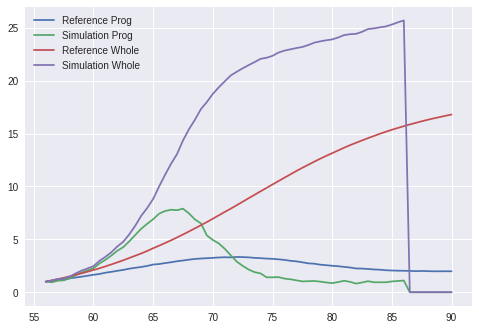

In [21]:
show_curve(res.stats, REF.stats)

In [22]:
for g in sorted(filter(sm.match, exp.list()), key=lambda x: int(sm.extract(x)["generation"])):
    gen = exp.load(g)
    res = pick_best(gen)
    print()
    print(f"======= GENERATION {g} =======")
    print(res.grn)


======= GENERATION generation_g0 =======
>> G_0: init: 1.00; noise: 0.15; b: 1.83; m: 1.46; expr: 1.00; deg: 0.10; theta: 7.60; asym: 5.00; tree : NOT 2
>> G_1: init: 1.03; noise: 0.39; b: 1.48; m: 2.08; expr: 1.00; deg: 0.10; theta: 1.45; asym: 5.00; tree : 5
>> G_2: init: 1.28; noise: 0.06; b: 1.07; m: 2.93; expr: 1.00; deg: 0.10; theta: 5.66; asym: 5.00; tree : NOT (1 OR 3)
>> G_3: init: 0.43; noise: 0.25; b: 0.10; m: 4.28; expr: 1.00; deg: 0.10; theta: 5.23; asym: 5.00; tree : 2
>> G_4: init: 0.59; noise: 0.40; b: 3.26; m: 4.70; expr: 1.00; deg: 0.10; theta: 5.97; asym: 5.00; tree : (4 OR 2)

======= GENERATION generation_g1 =======
>> G_0: init: 1.00; noise: 0.15; b: 1.83; m: 1.46; expr: 1.00; deg: 0.10; theta: 8.46; asym: 5.00; tree : NOT 2
>> G_1: init: 1.03; noise: 0.39; b: 1.48; m: 2.08; expr: 1.00; deg: 0.10; theta: 1.58; asym: 5.00; tree : 5
>> G_2: init: 1.28; noise: 0.06; b: 1.07; m: 2.93; expr: 1.00; deg: 0.10; theta: 5.89; asym: 5.00; tree : NOT (1 OR 3)
>> G_3: init: 0